In [26]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn import mixture
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from statsmodels.tools import add_constant
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel as C
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, RationalQuadratic, DotProduct
import statsmodels.api as sm
import random
from matplotlib import pyplot as plt
import os

# import tensorflow as tf
# import GPflow
# import george
# george.__version__
# from george import kernels

%matplotlib inline
sns.set(style="ticks")

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

<h3> Define functions needed for Gaussian process model </h3>

In [5]:
def get_filenames(folderpath):
    filenames = os.listdir(folderpath)
    return filenames

In [6]:
"""Reading CO2 hourly Data for 6/19 in Boston"""

def read_csv_file(file):
    df = pd.read_csv(file)
    return df

In [8]:
"""
Reads in multiple csv files given list of filenames/paths
Returns dataframe containing combined concatenated file contents
"""

def read_multiple_csvs(filename_list, local_path):

    DFlist = []

    for i in range(0,6):
        DF = pd.read_csv(local_path + filename_list[i], engine='python')
        # hold = DF["Sample Collection Start Time"]
        # DF["Sample Collection Start Time"] = hold + 24*i
        DFlist.append(DF)
        
    big_dataframe = pd.concat(DFlist)
    
    return big_dataframe

In [9]:
"""Cleans the times to a parsable format"""

def clean_time(col_name):
    times = []
    time = list(df[col_name])
    for i in range(len(time)):
        times.append(float(time[i][:2]))
    df[col_name] = times #could cause error
    return df

In [17]:
"""Cleans the times to a parsable format for multiple days in a row"""
def clean_time_multiple(DF, col_name):
    
    times = []
    time = list(DF[col_name])
    
    prev_T = float(time[0][:2])
    day = 0
    
    for i in range(len(time)):
        T = float(time[i][:2])
        if prev_T > T:
            day += 1
        times.append(T + day*24)
        prev_T = T
    
    DF[col_name] = times
    
    return DF

In [10]:
"""Splits dataframe into train and test data"""
def split_train_test(df):
    train, test = train_test_split(df, test_size=.30, random_state=0)
    x_train = train["Sample Collection Start Time"]
    y_train = train["Measure Value"]
    x_test = test["Sample Collection Start Time"]
    y_test = test["Measure Value"]
    return x_train, y_train, x_test, y_test

In [11]:
"""Plots level of air pollutant with respect to time for x train and y train"""
def plot_original(x_train, y_train):
    plt.scatter(x_train, y_train)
    plt.ylabel("Measure Value")
    plt.xlabel("Time Occurred")
    plt.title("Boston CO2 level on 6/19")
    plt.show()

In [22]:
"""
Creates Gaussian model, computs r squarred, MSE and log liklihood
Given x_train, y_train, x_test, and y_test data, and numerical alpha value
Prints train and test R^2

"""

def simple_gaussian(x_train, y_train, x_test, y_test, alpha):
    
    train_size = x_train.shape[0]
    test_size = x_test.shape[0]
    
    kern = RBF(length_scale = 1)
    
    gp = GaussianProcessRegressor(kernel=kern, alpha=alpha, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=False, copy_X_train=False, random_state=None)
    gp.fit(x_train.reshape(train_size, 1), y_train.reshape(train_size, 1))

    y_train_pred, sigma_train = gp.predict(x_train.reshape(train_size, 1), return_std=True)
    y_test_pred, sigma_test = gp.predict(x_test.reshape(test_size, 1), return_std=True)

    # get R^2
    r2 = gp.score(x_train.reshape(train_size, 1), y_train.reshape(train_size, 1))
    r2_t = gp.score(x_test.reshape(test_size, 1), y_test.reshape(test_size, 1))

    # get MSE measurements
    MSE_test = np.mean((y_test_pred - y_test.reshape(test_size, 1))**2)
    MSE_train = np.mean((y_train_pred - y_train.reshape(train_size, 1))**2)

    # get log likelihood
    t = gp.log_marginal_likelihood()

    # calculate AIC
    AIC = 2*len(x_test) - 2*np.log(-t)
    
    # print R^2 values
    print('mean squared error of train data with model = ' + str(MSE_train))
    print('mean squared error of test data with model = ' + str(MSE_test))
    print('Akaike information criterion = ' + str(AIC))
    print('log likelihood of model = ' + str(t))
    print('training R^2 value = ' + str(r2))
    print('testing R^2 value = ' + str(r2_t))
    
    return y_train_pred, y_test_pred, gp

In [20]:
"""Plots predicted y values for testing set"""
def plot_predictions(x_test, y_test, y_test_pred, x_label, y_label):
    plt.figure(figsize=(13,8))
    plt.plot(x_test, y_test, ".", color="r",)
    plt.scatter(x_test, y_test_pred)
    plt.xlabel(x_label)
    plt.title(y_label)
    plt.show()

<h3> Kaela and Annamira's Gaussian models: </h3>

<h3> Gaussian process (six days in a row) </h3>

In [15]:
pollutants = ['CO', 'SO', 'NO', 'OZO', 'PM']
local_path = 'Boston_AQ_Hourly/'

alphas = [0.000888, 0.00000001, 0.000001, 0.00001, 0.000588]

x_label = 'Time'
y_labels = pollutants

/Users/Annamira/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in log


mean squared error of train data with model = 0.00036508524601
mean squared error of test data with model = 0.00218773147039
Akaike information criterion = nan
log likelihood of model = 431.704731015
training R^2 value = 0.926712995394
testing R^2 value = 0.406542354493


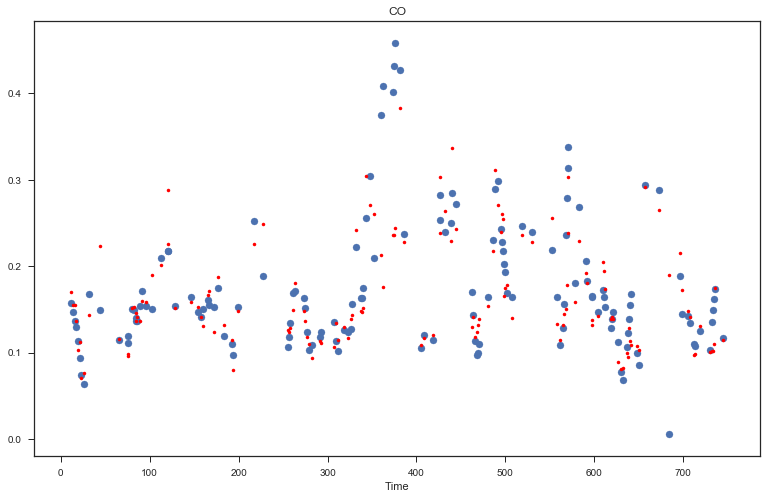

mean squared error of train data with model = 4.43791533971e-12
mean squared error of test data with model = 0.0134004336989
Akaike information criterion = nan
log likelihood of model = 16.3210520105
training R^2 value = 0.999999999109
testing R^2 value = -2.63508499072


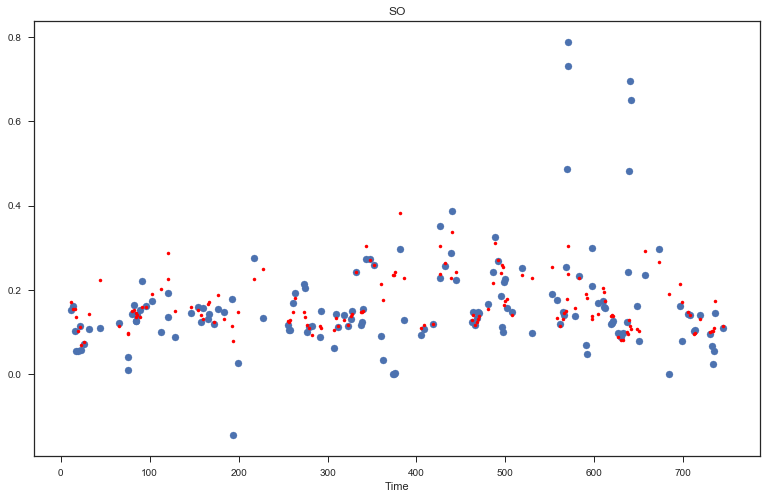

mean squared error of train data with model = 3.95860249807e-08
mean squared error of test data with model = 0.0142340665397
Akaike information criterion = nan
log likelihood of model = 22.058907658
training R^2 value = 0.999992053524
testing R^2 value = -2.86122141998


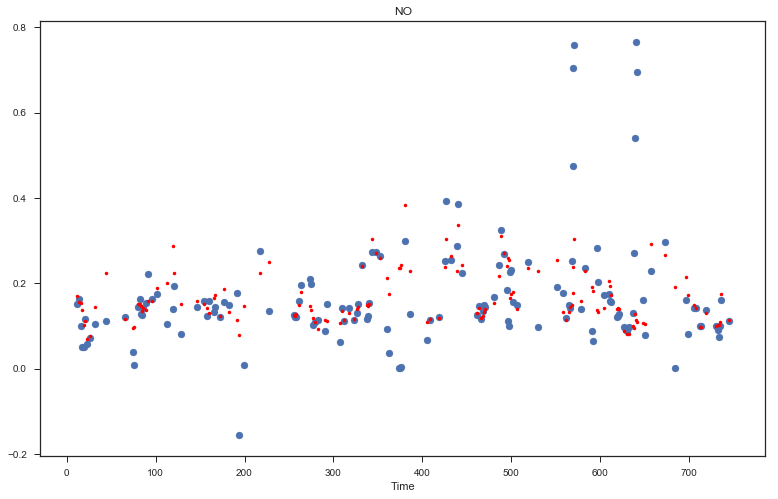

mean squared error of train data with model = 5.27831008084e-06
mean squared error of test data with model = 0.0151370001366
Akaike information criterion = nan
log likelihood of model = 95.7002171431
training R^2 value = 0.998940435037
testing R^2 value = -3.10615680339


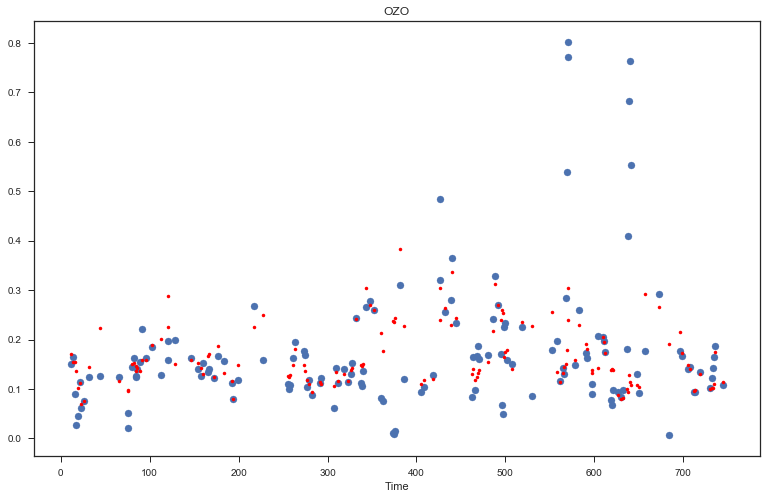

mean squared error of train data with model = 0.00169684392181
mean squared error of test data with model = 0.00183767738593
Akaike information criterion = nan
log likelihood of model = 311.746874598
training R^2 value = 0.659376516385
testing R^2 value = 0.501500202645


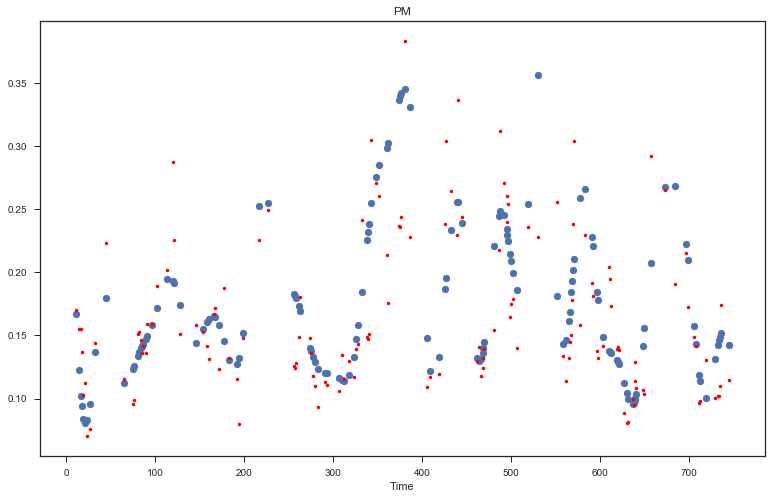

In [29]:
for i in range(0,5):

    filenames = get_filenames(local_path + pol + '/')

    DF = read_multiple_csvs(filenames, local_path + pol + '/')

    DF = clean_time_multiple(DF, 'Sample Collection Start Time')
    
    file = open('appendedAQ.csv', 'w')
    DF.to_csv(file)
    file.close()

    x_train, y_train, x_test, y_test = split_train_test(DF)

    y_train_pred, y_test_pred, gp = simple_gaussian(x_train, y_train, x_test, y_test, alphas[i])

    plot_predictions(x_test, y_test, y_test_pred, x_label, y_labels[i])